# Prediction of % female-headed households in RSA using Gradient Boosting algorithms

This notebook contains:
1. Testing different boosting algorithms
2. Optimization of the best algorithm with GridSearch => XGBoost
3. Error analysis

## 1. Testing different boosting algorithms

To obtain the best prediction model, different gradient boosting models are tested. For this task, we chose AdaBoost, GBDT and XGBoost. The selected features derive from the feature importance in a random forest model ('psa_00', 'car_01', 'pw_00', 'lln_01', 'pg_00').

In [6]:
# import libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import  GradientBoostingRegressor
from xgboost import XGBRFRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

RSEED = 42

In [7]:
# import data
#df = pd.read_csv("/Users/janaconradi/neuefische/Zindi_Data_female_households_RSA/data/Train.csv")
df = pd.read_csv("../data/Train.csv")


In [8]:
#define X (with selected values) and y values
X = df[['psa_00', 'car_01', 'pw_00', 'lln_01', 'pg_00']]
y = df["target"]

In [9]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [17]:
# train Boosting regressor
ada = AdaBoostRegressor(random_state=RSEED, n_estimators=100)
gbdt = GradientBoostingRegressor(random_state=RSEED)
xgb = XGBRFRegressor(random_state=RSEED)

regressors = {"AdaBoost": ada, "GradientBoostingRegressor": gbdt, "XGBRFRegressor": xgb}

for model, regressor in regressors.items():
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print(f"RMSE {model}: {round(mean_squared_error(y_test, y_pred, squared=False),2)}")
    print(f"R2 {model}: {round(r2_score(y_test, y_pred),2)}")
    improvement = -100 * (round(mean_squared_error(y_test, y_pred, squared=False),3)-6.227)/6.227
    print('Improvement to baseline model: {:0.2f}%'.format(improvement))

RMSE AdaBoost: 4.31
R2 AdaBoost: 0.81
Improvement to baseline model: 30.85 %
RMSE GradientBoostingRegressor: 3.9
R2 GradientBoostingRegressor: 0.85
Improvement to baseline model: 37.31 %
RMSE XGBRFRegressor: 3.88
R2 XGBRFRegressor: 0.85
Improvement to baseline model: 37.61 %


### Conclusion

XGBoost archieves the lowest RMSE value (3.88) and the highest R2 value (0.85) and will therefore be chosen as a suitable predictor.

## 2. Optimizing the XGBoost model

As XGBoost archieved the best results, the model will be further tweaked and evaluated.

### Gridsearch and Crossvalidation for best hyperparameters

In [11]:
# Defining parameter grid (as dictionary)
param_grid = {'gamma': [0, 1, 10, 100],
 'max_depth': [4, 5, 6, 8],
 'min_child_weight': [1, 2]
}

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(XGBRFRegressor(random_state=RSEED), param_grid, scoring='r2',
                  cv=5, n_jobs=-1)

# Fit gridsearch object to data
gs.fit(X_train, y_train)

/Users/christinemerkel/neuefische/Zindi_Data_female_households_RSA/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/christinemerkel/neuefische/Zindi_Data_female_households_RSA/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/christinemerkel/neuefische/Zindi_Data_female_households_RSA/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/christinemerkel/neuefische/Zindi_Data_female_households_RSA/.venv/lib/python3.9/site

GridSearchCV(cv=5,
             estimator=XGBRFRegressor(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      max_delta_step=None, max_depth=None,
                                      min_child_weight=None, missing=nan,
                                      monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None,
                                      objective='reg:squarederror',
                                      predictor=None, random_state=42,
                                      reg_alpha=None, scale_pos_weight=None,
           

In [12]:
# Check the best hyperparameter found by GridSearch
gs.best_params_

{'gamma': 10, 'max_depth': 8, 'min_child_weight': 2}

In [13]:
# train XGBoost regressor with best params
xgb = XGBRFRegressor(random_state=RSEED, **gs.best_params_)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [14]:
#evaluation metrics
print(f"RMSE: {round(mean_squared_error(y_test, y_pred, squared=False),3)}")
print(f"R2: {round(r2_score(y_test, y_pred),3)}")

RMSE: 3.901
R2: 0.848


### Conclusion

The Gridsearch could not further improve the model.

## 3. Error Analysis

Here, we shortly take a look at the distribution of the residual of the XGBoost model.

/Users/christinemerkel/neuefische/Zindi_Data_female_households_RSA/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


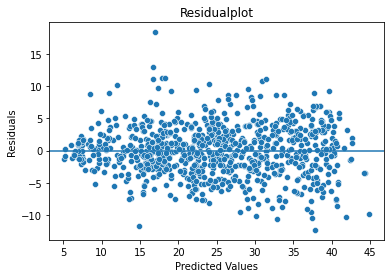

In [15]:
# plot residuals
residuals = y_test - y_pred
fig,ax=plt.subplots()
sns.scatterplot(y_pred, residuals, ax=ax)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title("Residualplot")
ax.axhline()
ax.plot();

### Conclusion

The residuals of the final model are almost randomly distributed. The model seem to slightly overpredict higher values.